# DivExplorer analysis - Example with COMPAS dataset 

In [1]:
%load_ext autoreload
%autoreload 2 

# Import dataset

In this running example we analyze the [COMPAS](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) dataset.

We import an already pre-processed and discretized version. You can refer to this [notebook](www.google.com) for its pre-processing.

The COMPAS dataset contains demographic information and the criminal history of defendants.
For each criminal defendant, the following attributes are available:
- *age_cat*: age category of the defendant. 
- *c_charge_degree*: severity of the charge. 'M'='Misdemeanor','F'='Felony' 
- *race*: 'Afr-Am', 'Asian', 'Cauc', 'Hispanic', 'Native American', 'Other'
- *sex*: 'Female', 'Male'
- *length_of_stay*: the days spent in jail, derived from the records of the date in which the person entered lastly the jail and the date in which the person was released.
- *priors_count*: the number of prior crimes committed.


For each defendant, the dataset also records:
- the *class*, whether the defendant recidivated (was arrested again) in the next two years. It is 1 if the defendant recidivated, 0 otherwise.
- the *predicted* recidivism, derived from the COMPAS score of recidivism risk assesses the defendant’s likelihood of committing another offense in a period of two years. It is 1 if the risk is high.

In [2]:
def get_true_positives(y_trues, y_preds, positive_value=1):
    """Returns true positives. True if it is a true positive, false otherwise."""

    return ((y_trues == y_preds) & (y_trues == positive_value))

def get_true_negatives(y_trues, y_preds, negative_value=1):
    """Returns true negatives. True if it is a true negative, false otherwise."""

    return ((y_trues == y_preds) & (y_trues == negative_value))

def get_false_positives(y_trues, y_preds, negative_value=1):
    """Returns false positives. True if it is a false positive, false otherwise."""

    return ((y_trues != y_preds) & (y_trues == negative_value))

def get_false_negatives(y_trues, y_preds, positive_value=1):
    """Returns false negatives. True if it is a false negative, false otherwise."""

    return ((y_trues != y_preds) & (y_trues == positive_value))

def get_false_positive_rate_outcome(y_trues, y_preds, negative_value=0):
    """Returns boolean outcome for the false positive rate. 1 if it is a false positive, 0 if it is a true negative, np.nan otherwhise.
    """
    import numpy as np

    fp = np.array(get_false_positives(y_trues, y_preds, negative_value=negative_value)).astype(int)
    tn = np.array(get_true_negatives(y_trues, y_preds, negative_value=negative_value)).astype(int)

    fp_outcome = np.full(fp.shape, np.nan)
    fp_outcome[fp == 1] = 1
    fp_outcome[tn == 1] = 0


    return fp_outcome

In [3]:
import os
inputDir=os.path.join(".", "notebooks", "datasets")

import pandas as pd
df = pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))
df.head()

,age,charge,race,sex,#prior,stay,class,predicted
0,>45,F,Other,Male,0,<week,0,0
1,25-45,F,Afr-Am,Male,0,1w-3M,1,0
2,<25,F,Afr-Am,Male,>3,<week,1,0
3,25-45,M,Other,Male,0,<week,0,0
4,25-45,F,Cauc,Male,>3,<week,1,0


In [4]:
y_trues = df["class"].values
y_preds = df["predicted"].values

In [5]:
df['fpr_outcome'] =  get_false_positive_rate_outcome(y_trues, y_preds, negative_value=0)

In [6]:
df = df.drop(columns=['class', 'predicted'])  

# Compute pattern divergence

With DivExplorer, we can compute the the performance metrics and the divergence scores of *all* itemsets whose frequency in the dataset is above a minimum frequency threshold (min_sup).

In [7]:
from divexplorer.divexplorer import DivergenceExplorer

min_sup = 0.1
fp_diver = DivergenceExplorer(
    df)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, boolean_outcomes = ['fpr_outcome'], show_coincise = True)
FP_fm.sort_values(by="support", ascending=False).head(10)

,support,itemsets,fpr_outcome,fpr_outcome_div,fpr_outcome_t,length,support_count
0,1.000000,(),0.088314,0.000000,0.000000,0,6172.0
1,0.809624,(sex=Male),0.093810,0.005496,0.738697,1,4997.0
2,0.772683,(stay=<week),0.072043,-0.016271,2.339352,1,4769.0
3,0.643227,(charge=F),0.107754,0.019440,2.301183,1,3970.0
4,0.614226,"(sex=Male, stay=<week)",0.076379,-0.011935,1.555571,2,3791.0
5,0.572262,(age=25-45),0.088842,0.000528,0.087728,1,3532.0
6,0.532404,"(charge=F, sex=Male)",0.111041,0.022727,2.471729,2,3286.0
7,0.514420,(race=Afr-Am),0.139366,0.051052,5.046409,1,3175.0
8,0.471484,"(charge=F, stay=<week)",0.088179,-0.000135,0.016780,2,2910.0
9,0.460629,"(sex=Male, age=25-45)",0.096377,0.008063,0.914899,2,2843.0


In [8]:
from divexplorer.pattern_processor import DivergencePatternProcessor

fp_diver = DivergencePatternProcessor(FP_fm, 'fpr_outcome')

pattern = fp_diver.patterns['itemsets'].iloc[30]
print(pattern)

sv = fp_diver.shapley_value(pattern)
sv

frozenset({'#prior=[1,3]', 'stay=<week'})


{frozenset({'#prior=[1,3]'}): -0.014328073142832076,
 frozenset({'stay=<week'}): -0.01534083615290903}

<BarContainer object of 2 artists>

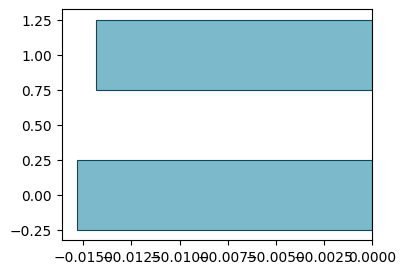

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi=100)

shapleyv_plot = {str(",".join(list(k))): v for k, v in sv.items()}

shapleyv_plot = {
    k: v for k, v in sorted(shapleyv_plot.items(), key=lambda item: item[1])
}

ax.barh(
    range(len(shapleyv_plot)),
    shapleyv_plot.values(),
    height=0.5,
    align="center",
    color="#7CBACB",
    linewidth=0.8,
    edgecolor="#0C4A5B",
)

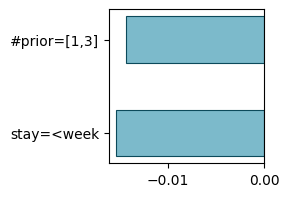

In [10]:
fp_diver.plot_shapley_value(pattern = pattern, figsize=(2,2))

In [35]:
fp_diver.redundancy_pruning(th_redundancy=0.05)

,support,itemsets,length,support_count,fpr_outcome,fpr_outcome_div,fpr_outcome_t
0,1.000000,(),0,6172.0,0.088314,0.000000,0.000000
7,0.514420,(race=Afr-Am),1,3175.0,0.139366,0.051052,5.046409
28,0.293422,(#prior=>3),1,1811.0,0.219269,0.130955,7.503321
44,0.218244,(age=<25),1,1347.0,0.177066,0.088752,5.456070
47,0.209494,(age=>45),1,1293.0,0.027304,-0.061010,8.097262
65,0.177090,(stay=1w-3M),1,1093.0,0.151786,0.063472,3.668118


In [38]:
fp_diver.dict_len_pattern_divergence

## Quantitative 

In [107]:
import os
import numpy as np

inputDir=os.path.join(".", "notebooks", "datasets")

import pandas as pd
df= pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))

df['score'] = [np.random.uniform() for i in range(len(df))]
df.drop(columns=['class', 'predicted'], inplace=True)

In [108]:
from divexplorer.divexplorer import DivergenceExplorer

min_sup = 0.1
fp_diver = DivergenceExplorer(
    df)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, quantitative_outcomes = ['score'], show_coincise = True)
FP_fm.sort_values(by="support", ascending=False).head(10)

,support,itemsets,score,score_SQUARED,score_div,score_t,length,support_count
0,1.000000,(),0.496463,2038.623380,0.000000,0.000000,0,6172.0
1,0.809624,(sex=Male),0.497202,1653.895029,0.000739,0.134217,1,4997.0
2,0.772683,(stay=<week),0.496247,1571.326790,-0.000216,0.038753,1,4769.0
3,0.643227,(charge=F),0.498284,1323.414146,0.001822,0.307882,1,3970.0
4,0.614226,"(stay=<week, sex=Male)",0.498384,1257.292226,0.001922,0.322309,2,3791.0
5,0.572262,(age=25-45),0.495080,1158.642115,-0.001383,0.227105,1,3532.0
6,0.532404,"(sex=Male, charge=F)",0.498657,1097.073096,0.002194,0.349080,2,3286.0
7,0.514420,(race=Afr-Am),0.501779,1066.935690,0.005316,0.839310,1,3175.0
8,0.471484,"(stay=<week, charge=F)",0.497400,966.062693,0.000938,0.143576,2,2910.0
9,0.460629,"(sex=Male, age=25-45)",0.496290,936.495267,-0.000173,0.026424,2,2843.0
